In [1]:
from sagas.nlu.uni_remote import dep_parse
from sagas.nlu.common import get_from_clip
from sagas.conf.conf import cf
from sagas.nlu.uni_remote_viz import list_chunks
from sagas.nlu.utils import fix_sents

from sagas.tracker_jupyter import enable_jupyter_tracker
enable_jupyter_tracker()

sents='Siapa yang menulis laporan ini?'
source='id'

sents=fix_sents(sents, source)
engine=cf.engine(source)
doc_jsonify, resp = dep_parse(sents, source, engine, ['predicts'])
print('ok, resp: ', resp)

.. request is {'lang': 'id', 'sents': 'Siapa yang menulis laporan ini?', 'engine': 'corenlp', 'pipelines': ['predicts']}
ok, resp:  {'predicts': []}


In [11]:
all([True, False])

False

In [40]:
all([])

True

In [3]:
def is_describe(w):
    return lambda doc, meta: w=='ok'
f=is_describe('ok')
is_describe('ok')({},{}), callable(f), callable(is_describe), callable('')

(True, True, True, False)

In [24]:
def it(*dl):
    rs=[]
    for d in dl:
        rs.extend(d)
    return rs

l=[[{'amod': 'putih'}], [{'punct': '.'}]]
print(*l)
it(*l)

[{'amod': 'putih'}] [{'punct': '.'}]


[{'amod': 'putih'}, {'punct': '.'}]

.. request is {'lang': 'id', 'sents': 'Bola Dimas putih.', 'engine': 'corenlp', 'pipelines': ['predicts']}
root is bola, compound ->  ['dimas']
compound domains ->  [{'amod': 'putih'}]
1. check match True
2. check fn True
3. check anal True
4. check anal error False
[('dimas', 'bola')]
[{'domains': [{'amod': 'putih'}], 'word': 'dimas'},
 {'domains': [{'punct': '.'}], 'word': 'bola'}]
✁ dependency-graph. -------------------------


,index,text,lemma,upos,xpos
0,1,Bola,bola,NOUN,NSD
1,2,Dimas,dimas,PROPN,VSP
2,3,putih,putih,ADJ,ASP
3,4,.,.,PUNCT,Z--


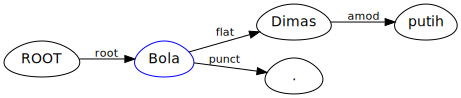

[root_domains](Bola) Ball
	[flat](Dimas putih) white Dimas


In [49]:
from sagas.nlu.corenlp_parser import get_subj_domain, get_root_domain
from sagas.nlu.uni_remote_viz import list_contrast, display_doc_deps
from pprint import pprint

def equals(a, b):
    return str(a) == str(b)

def head(word, sent):
    c=sent.words[word.governor - 1]
    return c
def children(word, sent):
    return filter(lambda w: equals(w.governor, word.index), sent.words)

def parse_sents(sents, source):
    sents=fix_sents(sents, source)
    engine=cf.engine(source)
    doc_jsonify, resp = dep_parse(sents, source, engine, ['predicts'])
    return doc_jsonify, resp

def check_part_match(domain_list, **kwargs):
    rs=[]
    for k,v in kwargs.items():
        for domain in domain_list:
            rs.append(k in domain and domain[k]==v)
    return all(rs)

def check_fn(domain_list, meta, **kwargs):
    # print('.. domains size', len(domain_list))
    if len(domain_list)==0:
        return False
    
    rs=[]    
    for k,v in kwargs.items():
        item_r=False
        for domain in domain_list:
            # 如果包含了该成分, 则这这个成分的测试值必须为真
            if k in domain and v(domain[k], meta):
                item_r=True
        # 如果domain_list里的所有元素都未包含该成分, 则会保留为false值
        rs.append(item_r)
    return all(rs) if len(rs)>0 else False

def predicate_fn(chain, pos):
    from sagas.nlu.inspector_wordnet import predicate
    return lambda word, meta: predicate(chain, word, meta["lang"], pos)

# sid 'Bola Dimas putih.'
text='Bola Dimas putih.'
# text='Lidah saya kering.'
lang='id'
# text='Kuku kucingmu panjang.'
doc, resp=parse_sents(sents=text, source=lang)
meta={'lang': lang, "sents": text, 'engine': 'corenlp'}

comp_rel=('flat', "compound")
get_domains=lambda w,doc: [{pa.dependency_relation:pa.lemma} for pa in children(w, doc) if pa.dependency_relation not in comp_rel]

def anal(**kwargs):
    def perform(doc, meta):
        root = next(w for w in doc.words if w.dependency_relation in ('root', 'hed'))
        compounds=[w for w in children(root, doc) if w.dependency_relation in comp_rel]
        check_r=check_fn(it(*[get_domains(c,doc) for c in compounds]), meta, **kwargs)
        return check_r
    return perform

# ...

root = next(w for w in doc.words if w.dependency_relation in ('root', 'hed'))
print(f"root is {root.lemma}", end=', ')
compounds=[w for w in children(root, doc) if w.dependency_relation in comp_rel]
print('compound -> ', [c.lemma for c in compounds])
print('compound domains -> ', *[get_domains(c,doc) for c in compounds])

check_r=check_part_match(it(*[get_domains(c,doc) for c in compounds]), amod='putih')
print('1. check match', check_r)
check_r=check_fn(it(*[get_domains(c,doc) for c in compounds]), meta, amod=predicate_fn('color', 'n'))
print('2. check fn', check_r)
check_r=anal(amod=predicate_fn('color', 'n'))
print('3. check anal', check_r(doc, meta))
check_r=anal(amod=predicate_fn('color', 'n'), unknown='xx')
print('4. check anal error', check_r(doc, meta))

pickups=list(filter(lambda w: w.dependency_relation in comp_rel, doc.words))
print([(word.lemma, head(word, doc).lemma) for word in pickups])

chunk=[]
for word in pickups:
    for w in [word, head(word,doc)]:
        chunk.append({'word':w.lemma, 'domains':get_domains(w,doc)})
pprint(chunk)
# ...
rs=get_root_domain(doc)
g=display_doc_deps(doc, resp)
display(g)
_=list_contrast(rs, source)

In [4]:
from pprint import pprint
from sagas.nlu.corenlp_parser import get_subj_domain

rs = get_subj_domain(doc_jsonify)
pprint(rs)

[{'domains': [('nsubj', '2', 'yang', 'yang', ['yang'], ['c_pron', 'x_s--']),
              ('obj',
               '4',
               'laporan',
               'laporan',
               ['laporan', 'ini'],
               ['c_noun', 'x_nsd'])],
  'governor': 3,
  'head': 'menulis',
  'head_feats': ['mentulis', 'VERB', 'VSA'],
  'head_pos': 'verb',
  'index': '2',
  'lemma': 'yang',
  'rel': 'nsubj',
  'stems': [('nsubj', ['yang']), ('obj', ['laporan', 'ini'])],
  'type': 'subj_domains',
  'word': 'yang'}]


In [5]:
from sagas.nlu.uni_remote_viz import list_contrast, display_doc_deps
_=list_contrast(rs, source)

[subj_domains](yang) that ⊙︿⊙ write
	[nsubj](yang) that
	[obj](laporan ini) this report


✁ dependency-graph. -------------------------


,index,text,lemma,upos,xpos
0,1,Siapa,siapa,PRON,W--
1,2,yang,yang,PRON,S--
2,3,menulis,mentulis,VERB,VSA
3,4,laporan,laporan,NOUN,NSD
4,5,ini,ini,DET,B--
5,6,?,?,PUNCT,Z--


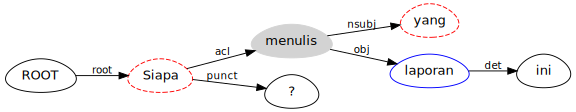

In [8]:
display_doc_deps(doc_jsonify, resp)

In [10]:
sent=doc_jsonify
verbs=list(filter(lambda w: w.upos == "VERB", sent.words))
[word.lemma for word in verbs]

['mentulis']

In [12]:
word=verbs[0]
for c in filter(lambda w: equals(w.governor, word.index), sent.words):
    print(c.lemma)

yang
laporan


In [16]:
print(word.governor)
dc = sent.words[word.governor - 1]
print(word.dependency_relation)
print(dc.lemma, dc.dependency_relation)

1
acl
siapa root


In [18]:
import fnmatch, re
regex = fnmatch.translate('*.txt')
print(regex)
reobj = re.compile(regex)
reobj.match('foobar.txt')

(?s:.*\.txt)\Z


<_sre.SRE_Match object; span=(0, 10), match='foobar.txt'>

In [20]:
reobj.match('foobar.tt') is None

True